use the spread 2Y and spread 5Y of swaps and take zscore of 1Y  
then take average between the 2 signals

# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
universe = G10_FX
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [3]:
settings = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=126, rebalance_period="daily",
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=126,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=252)

# Other Data

In [4]:
swaps = pd.read_csv("../../Dymon/Code Data/swaps.csv", index_col=0).iloc[2:]

In [5]:
swaps.columns = ["2Y", "5Y"]
swaps = swaps.astype(float)
swaps.index = pd.to_datetime(swaps.index)

In [6]:
spread_2y = swaps["2Y"]
spread_5y = swaps["5Y"]
spread_2y.index.name = "date"
spread_5y.index.name = "date"

# Data integrity

In [7]:
pd.concat([spread_2y.pipe(fill_date), spread_5y.pipe(fill_date)], axis=1).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5645 entries, 2000-01-03 to 2021-08-20
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2Y      5644 non-null   float64
 1   5Y      5644 non-null   float64
dtypes: float64(2)
memory usage: 132.3 KB


<AxesSubplot:>

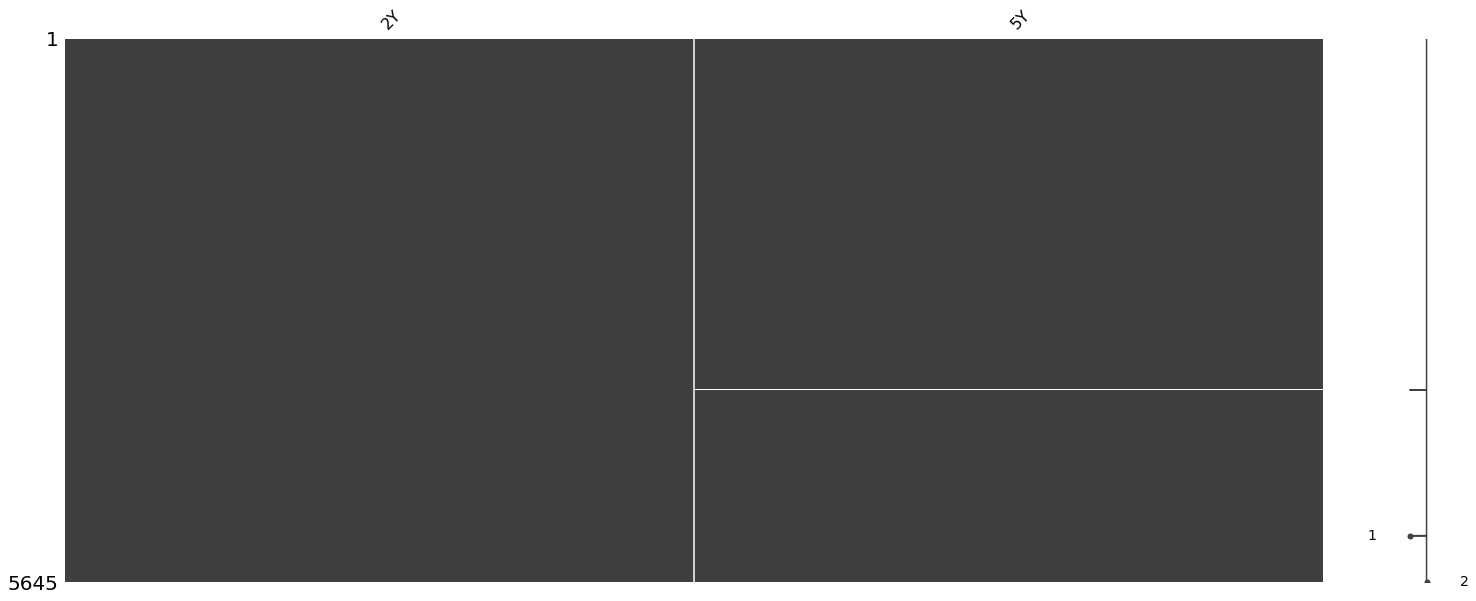

In [8]:
msmx(pd.concat([spread_2y.pipe(fill_date), spread_5y.pipe(fill_date)], axis=1))

# Signal

In [9]:
## 1Y zscore of 5Y swap spread, capped at 2
signal_5y = spread_5y.pipe(fill_date, True).pipe(omit_trailing_na).pipe(zscore, 252, typ="median").pipe(cap_helper, 2)

## 1Y zscore of 2Y swap spread, capped at 2
signal_2y = spread_2y.pipe(fill_date, True).pipe(omit_trailing_na).pipe(zscore, 252, typ="median").pipe(cap_helper, 2)

## Equal weighted average
signal = (signal_5y + signal_2y)/2

## Slow down using 5-day simple moving average
signal = signal.pipe(rolling_mean, 5)

sig = pd.concat([signal] * len(total_returns.columns), axis=1)
sig.columns = total_returns.columns
sig.index = pd.to_datetime(sig.index)

# Backtest Daily Rebal

In [10]:
daily_bt = Backtest(signal = sig, asset_returns = total_returns, tcost = abs(total_returns*0), settings = settings)
daily_bt.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [11]:
get_summary(daily_bt)

Returns   : 0.044924437720417626
Vol       : 0.10770136563960035
SR        : 0.41712040932468464
Max DD    : -32.64

C Returns : 0.039902504749881586
C SR      : 0.4045136387750586
C Max DD  : -29.35

Hit rate  : 0.513
W | N | L : 0.51 | 0.0 | 0.49
W/L Ratio : 1.05


In [27]:
get_returns_stats(daily_bt.asset_rtn, daily_bt.wts)

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK,USDCHF
annualized_return,0.865659,0.458401,0.519747,0.057044,0.057838,0.565646,0.43908,0.651581,0.489486
sharpe,0.559458,0.294014,0.334018,0.03657,0.038536,0.368751,0.28924,0.41563,0.30484
dollar_sharpe,0.563754,0.2962,0.328461,0.02911,0.031345,0.36512,0.281637,0.415033,0.298037
trade_sharpe,0.559458,0.294014,0.334018,0.03657,0.038536,0.368751,0.28924,0.41563,0.30484
long_sharpe,0.16532,0.080173,0.171,-0.249257,0.344049,-0.157222,0.017008,0.19838,0.121464
short_sharpe,0.907162,0.464952,0.479557,0.226421,-0.180843,0.802174,0.500302,0.605154,0.453364
sortino,0.355646,0.180247,0.2109,0.021994,0.023249,0.240393,0.177238,0.250126,0.185252
max_drawdown,-3.092853,-4.651193,-4.210561,-8.25898,-7.049016,-4.831636,-4.094369,-4.911332,-4.37688
max_drawdown_start,2003-07-03,2003-06-13,2008-12-17,2003-06-17,2010-10-29,2003-07-07,2003-06-13,2003-05-29,2011-08-09
max_drawdown_end,2007-07-25,2007-03-05,2010-06-07,2014-07-02,2014-07-17,2005-12-05,2007-07-20,2007-07-16,2012-07-24


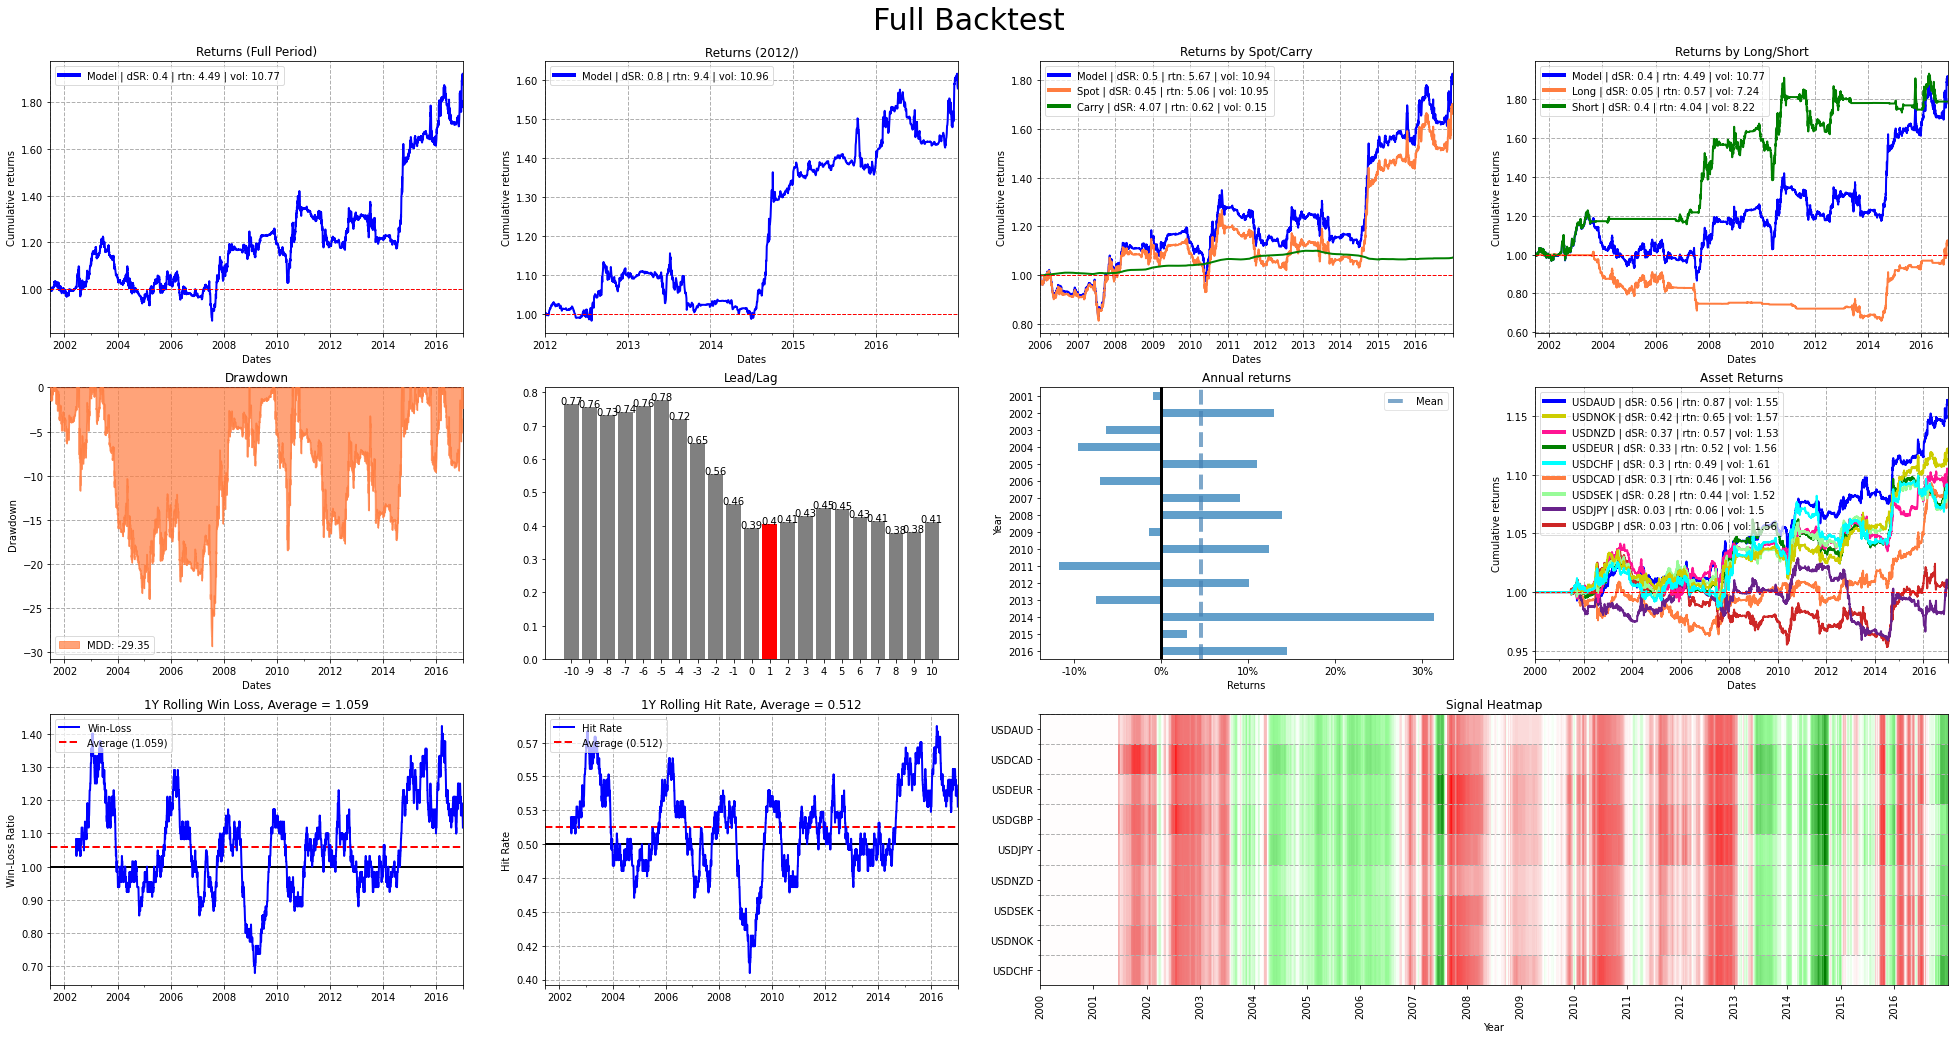

In [28]:
plot_bt(daily_bt)

# Backtest Weekly Rebal

In [29]:
weekly_bt = Backtest(signal = sig, 
             asset_returns = total_returns, 
             tcost = abs(total_returns*0), 
             settings = settings,
             settings_inject = {"rebalance_period":"friday"})
weekly_bt.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [30]:
get_summary(weekly_bt)

Returns   : 0.05155335004957967
Vol       : 0.10817741896995348
SR        : 0.47656295131148146
Max DD    : -25.56

C Returns : 0.04676431155118507
C SR      : 0.4643002175688109
C Max DD  : -24.15

Hit rate  : 0.517
W | N | L : 0.52 | 0.0 | 0.48
W/L Ratio : 1.07


In [31]:
get_returns_stats(weekly_bt.asset_rtn, weekly_bt.wts)

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK,USDCHF
annualized_return,0.932742,0.503485,0.633417,0.168098,0.074386,0.676679,0.551142,0.69354,0.473152
sharpe,0.601887,0.322273,0.40591,0.105271,0.049346,0.439628,0.364322,0.443274,0.292623
dollar_sharpe,0.604649,0.325922,0.401659,0.098448,0.04229,0.434536,0.357341,0.443013,0.284191
trade_sharpe,0.601887,0.322273,0.40591,0.105271,0.049346,0.439628,0.364322,0.443274,0.292623
long_sharpe,0.231522,0.155017,0.238693,-0.170663,0.323172,0.002523,0.113727,0.242262,0.156978
short_sharpe,0.940792,0.46457,0.561569,0.29231,-0.144873,0.817851,0.566737,0.623817,0.407403
sortino,0.384341,0.198489,0.255769,0.061806,0.029538,0.287369,0.22308,0.269303,0.171726
max_drawdown,-2.404754,-4.366337,-3.596643,-6.78021,-7.016064,-3.922385,-3.329617,-4.083997,-4.321502
max_drawdown_start,2006-03-28,2003-06-13,2008-12-17,2003-06-17,2010-10-29,2003-09-02,2005-11-16,2003-05-29,2011-08-09
max_drawdown_end,2007-07-25,2007-03-05,2010-06-07,2014-07-02,2013-06-14,2005-12-05,2007-07-20,2007-07-16,2012-07-24


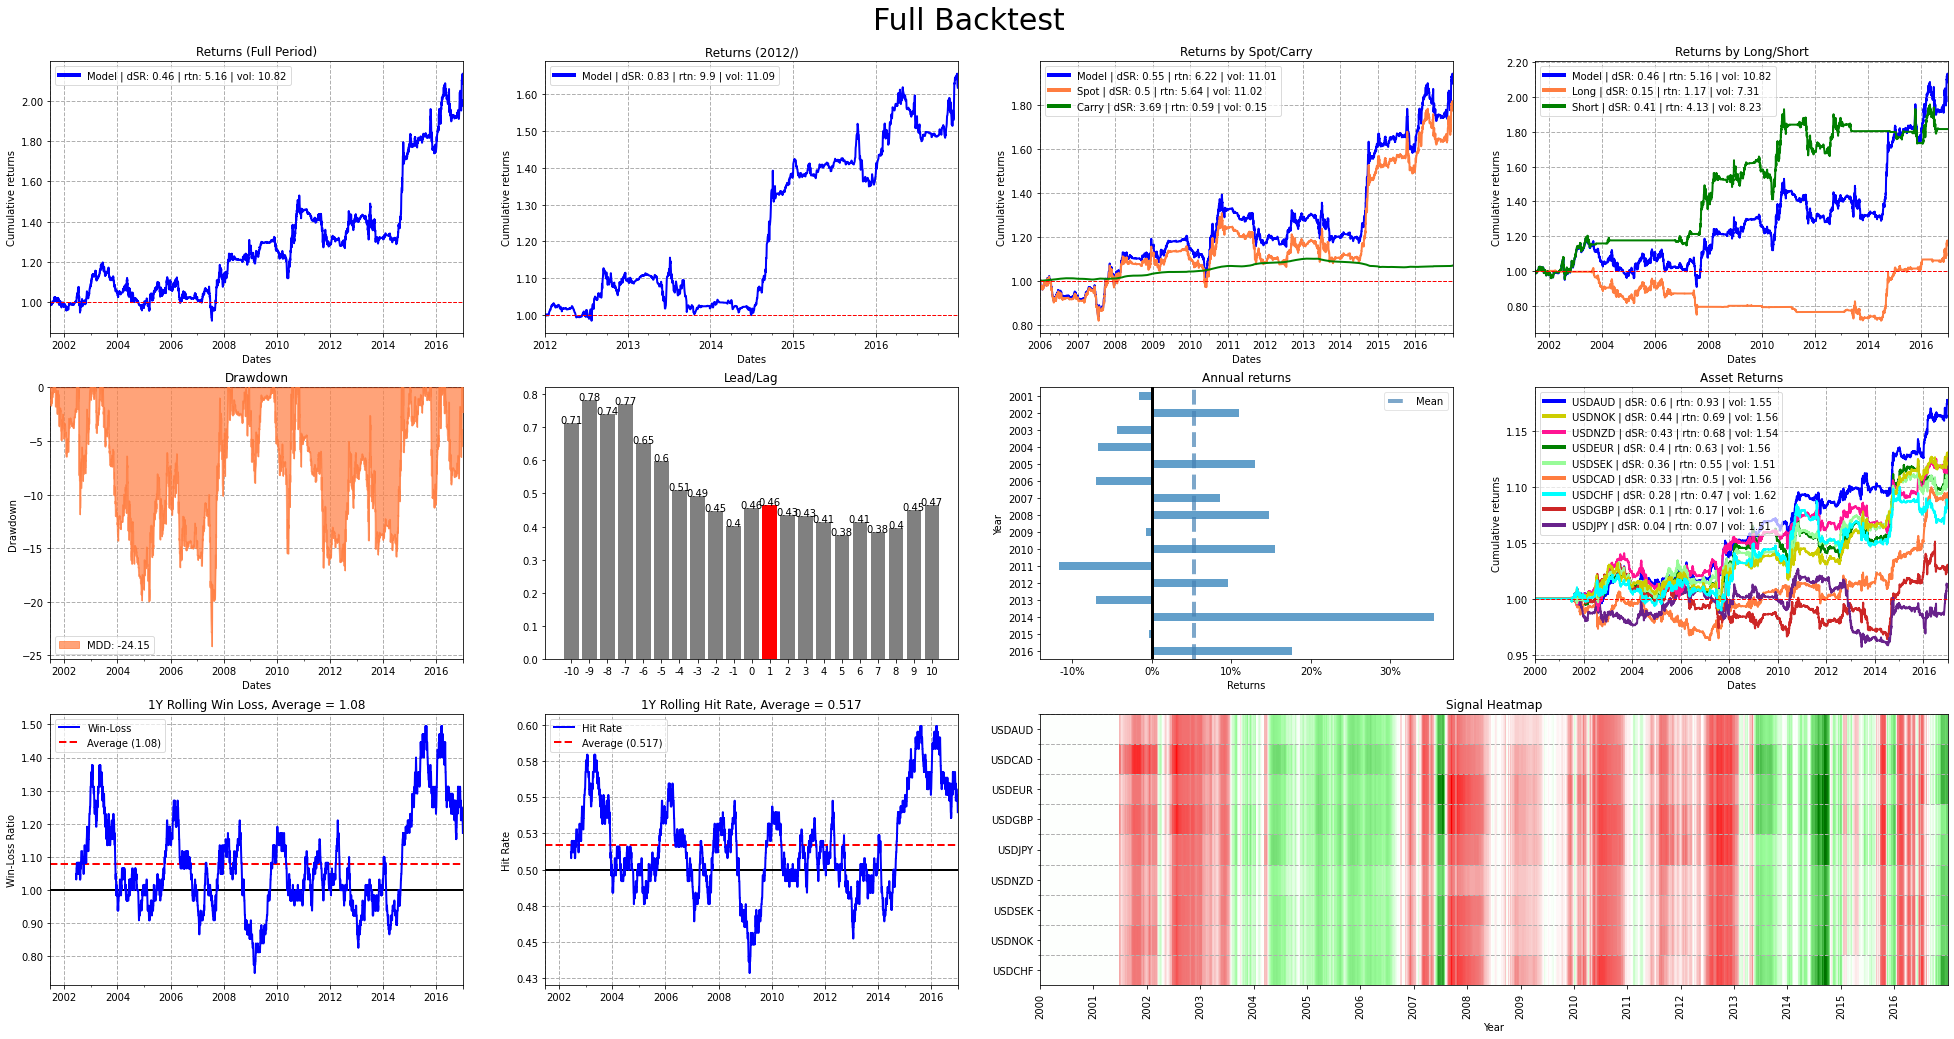

In [32]:
plot_bt(weekly_bt)

# Daily vs Weekly 

<AxesSubplot:title={'center':'Daily vs Weekly Rebal'}, xlabel='Dates', ylabel='Cumulative returns'>

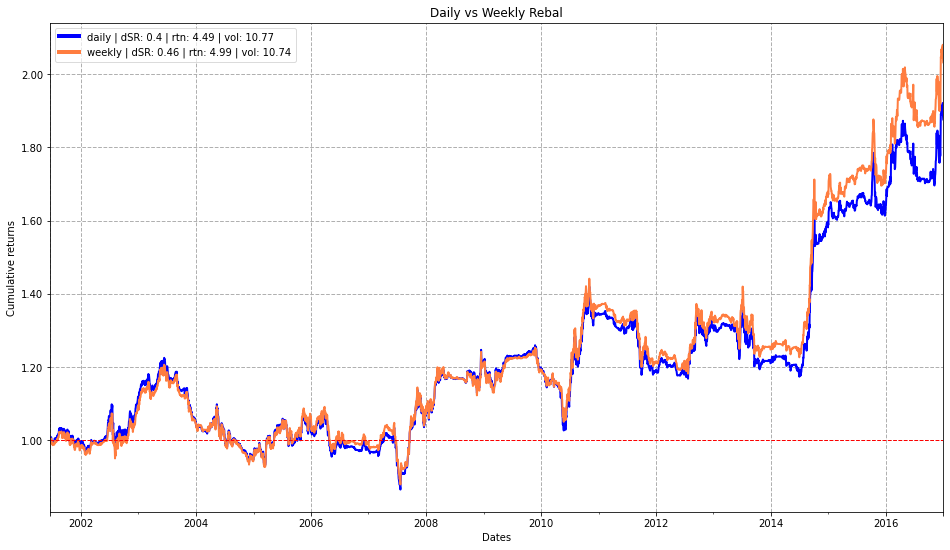

In [18]:
gen_plot_rtn(pd.concat([daily_bt.model_rtn.rename("daily"), weekly_bt.model_rtn.rename("weekly")], axis=1), main = "Daily vs Weekly Rebal")

In [33]:
# pickle.dump(daily_bt, open("../BT/carry_unwinding_g10_daily.p", "wb"))
# daily_bt = pickle.load(open("../BT/carry_unwinding_g10_daily.p", "rb"))

# pickle.dump(weekly_bt, open("../BT/carry_unwinding_g10_weekly.p", "wb"))
# weekly_bt = pickle.load(open("../BT/carry_unwinding_g10_weekly.p", "rb"))

# Regime Plot

# Sensitivity Analysis

In [20]:
# pf.plot_monthly_returns_dist(bt_obj.model_rtn)